# KKBox Customer Segmentation Analysis
### w/ BigQuery and Apache Spark

---

# Part 2: <font color=green>*Segmentation Analysis*</font>

---

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#### - <font color=purple>*Import Data*</font> -

In [5]:
DRV_Jan2016_Clust = pd.read_csv('D:\J-5 Local\DRV_Jan2016_With_Cluster')

In [6]:
# Create list of Categorical feature names
cat_feats = ['is_auto_renew', 'total_spent_zero', 'city_agg', 'payment_method_agg', 'never_active_subscriber']

# Create list of Continuous feature names
cont_feats = [x for x in DRV_Jan2016_Clust.columns if x not in cat_feats]
cont_feats.remove('msno')
cont_feats.remove('is_churn')
cont_feats.remove('membership_expire_date')
cont_feats.remove('registration_init_time')
cont_feats.remove('city')
cont_feats.remove('bd')
cont_feats.remove('payment_method_id')
cont_feats.remove('is_net_paid_amount')
cont_feats.remove('registered_via')
cont_feats.remove('Cluster')

In [7]:
# Create list of all significant features
cont_feats_sig = cont_feats.copy()
cont_feats_sig.remove('total_secs_last_120')
cont_feats_sig.remove('total_secs_last_120_AVG')
cont_feats_sig.remove('DIFSTD_songs50_30_45_45_60')
cont_feats_sig.remove('Unnamed: 0')

#### - <font color=purple>*Split Up Features By Theme*</font> -

First, we will start by splitting up our features into themes to make our analysis more intuitive.

In [39]:
# Aggregate Activity Features
agg_total_feats = ['membership_length', 'total_songs', 'total_logins', 'sum_num_unq', 'sum_num_repeat', 'sum_over_50pec', 'sum_over_75pec', 'sum_over_985pec']

# Transaction Features
trans_cont_feats = ['plan_list_price', 'total_transactions', 'total_spent', 'spent_per_logins', 'spent_per_song']
trans_cat_feats = ['is_net_paid_amount', 'is_auto_renew', 'total_spent_zero']

# Aggregate Activity Time Interval Features
agg_TI_feats = ['songs_last_15', 'songs_last_30', 'logins_last_15', 'logins_last_30', 'total_secs_last_15' ,'total_secs_last_30', 'num_unq_last_15', 'num_unq_last_30', 
                'num_repeat_last_15', 'num_repeat_last_30', 'over_50perc_last_15', 'over_50perc_last_30', 'over_985perc_last_15', 'over_985perc_last_30']

# Comparative Activity Features
agg_block_feats = []

### <font color=blue>Cluster Group vs Churn</font>

### - <font color=purple>*Total and Relative Size of Clusters*</font> -

In [25]:
# Total and Relative Size of Cluses
clust_size = pd.DataFrame(DRV_Jan2016_Clust['Cluster'].value_counts())
clust_size['Relative Size'] = clust_size['Cluster'] / DRV_Jan2016_Clust.shape[0]
clust_size.columns = ['Cluster Size', 'Relative Size']
clust_size

,Cluster Size,Relative Size
1,290368,0.419668
0,285603,0.412781
2,100085,0.144653
3,15843,0.022898


- Cluster 0 and 1 make up over 80% of our train population. 
- With Cluster 3 being so small it leads me to believe that it maybe be an "outlier cluster". 
- K-Means is quite an efficient algorithm when it comes to handling outlier. Most of the time it will cluster outlier-observations into a single group. We will explore this futher soon.

### - <font color=purple>*Cluster Label vs Churn*</font> -

In [31]:
# create crosstab: Cluster vs Churn, also calculate % of User Churn per Cluster
count_table = pd.crosstab(DRV_Jan2016_Clust["Cluster"], DRV_Jan2016_Clust["is_churn"])
count_table['Is_Churn %'] = count_table[1] / (count_table[0] + count_table[1])
count_table

is_churn,0,1,Is_Churn %
Cluster,,,
0,280753,4850,0.016982
1,277337,13031,0.044878
2,98947,1138,0.011370
3,15714,129,0.008142


- Here we observe a significant difference between each of our cluster groups. 
- Cluster 0 and 1 are virtually the same size yet the latter has more than 2.5X the amount of churned users compared to the former.
- Although Cluster 0 and 2 have a similar relative rate of churn, I wonder if both of these groups have similarities in behaviour.
- Cluster 3 didnt even break 1% in relative churn.

### <font color=blue>Cluster Group vs Aggregate Activity Features</font>

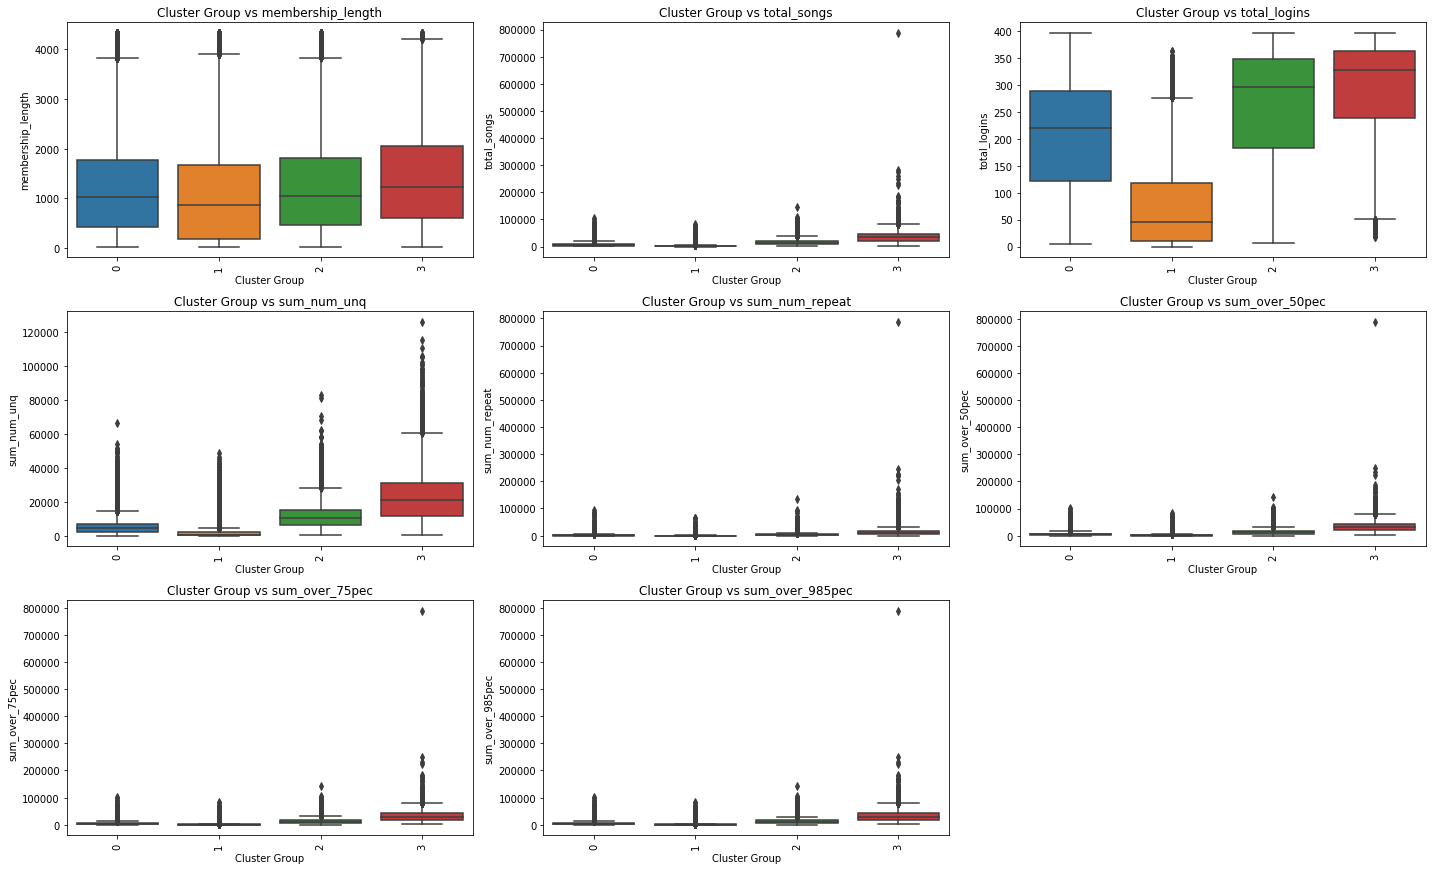

In [36]:
# Categorical TargetVar vs Cont_feats
plt.figure(figsize=(20,60))

for index, column in enumerate(agg_total_feats):
    plt.subplot(15,3,index+1)
    sns.boxplot(DRV_Jan2016_Clust['Cluster'],DRV_Jan2016_Clust[column])
    plt.title(f"Cluster Group vs {column}")
    plt.ylabel(column)
    plt.xlabel('Cluster Group')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

- Although all clusters have significant differences across all plots, **Membership Length** seems to be more or less stable interms of median values. This leads me to believe that ***activity*** is more import than ***tenure***.
- Making up almost half of the population, Cluster 1 users are the least active and performing the worst across categories. Cluster 3 users are clearly the most active
- Clusters 0 and 2 users have clear but more subtle differences compared to the other two. Cluster 2 does edge out Cluster 0 in terms of activity but don't forget that there isnt much difference in terms of relative churn. 

In the next step we will break these features up over different time intervals. Although I believe that their wont be much of a difference in behavior and distribution, we must always be thorough.

### <font color=blue>Cluster Group vs Aggregate Activity Time Interval Features</font>

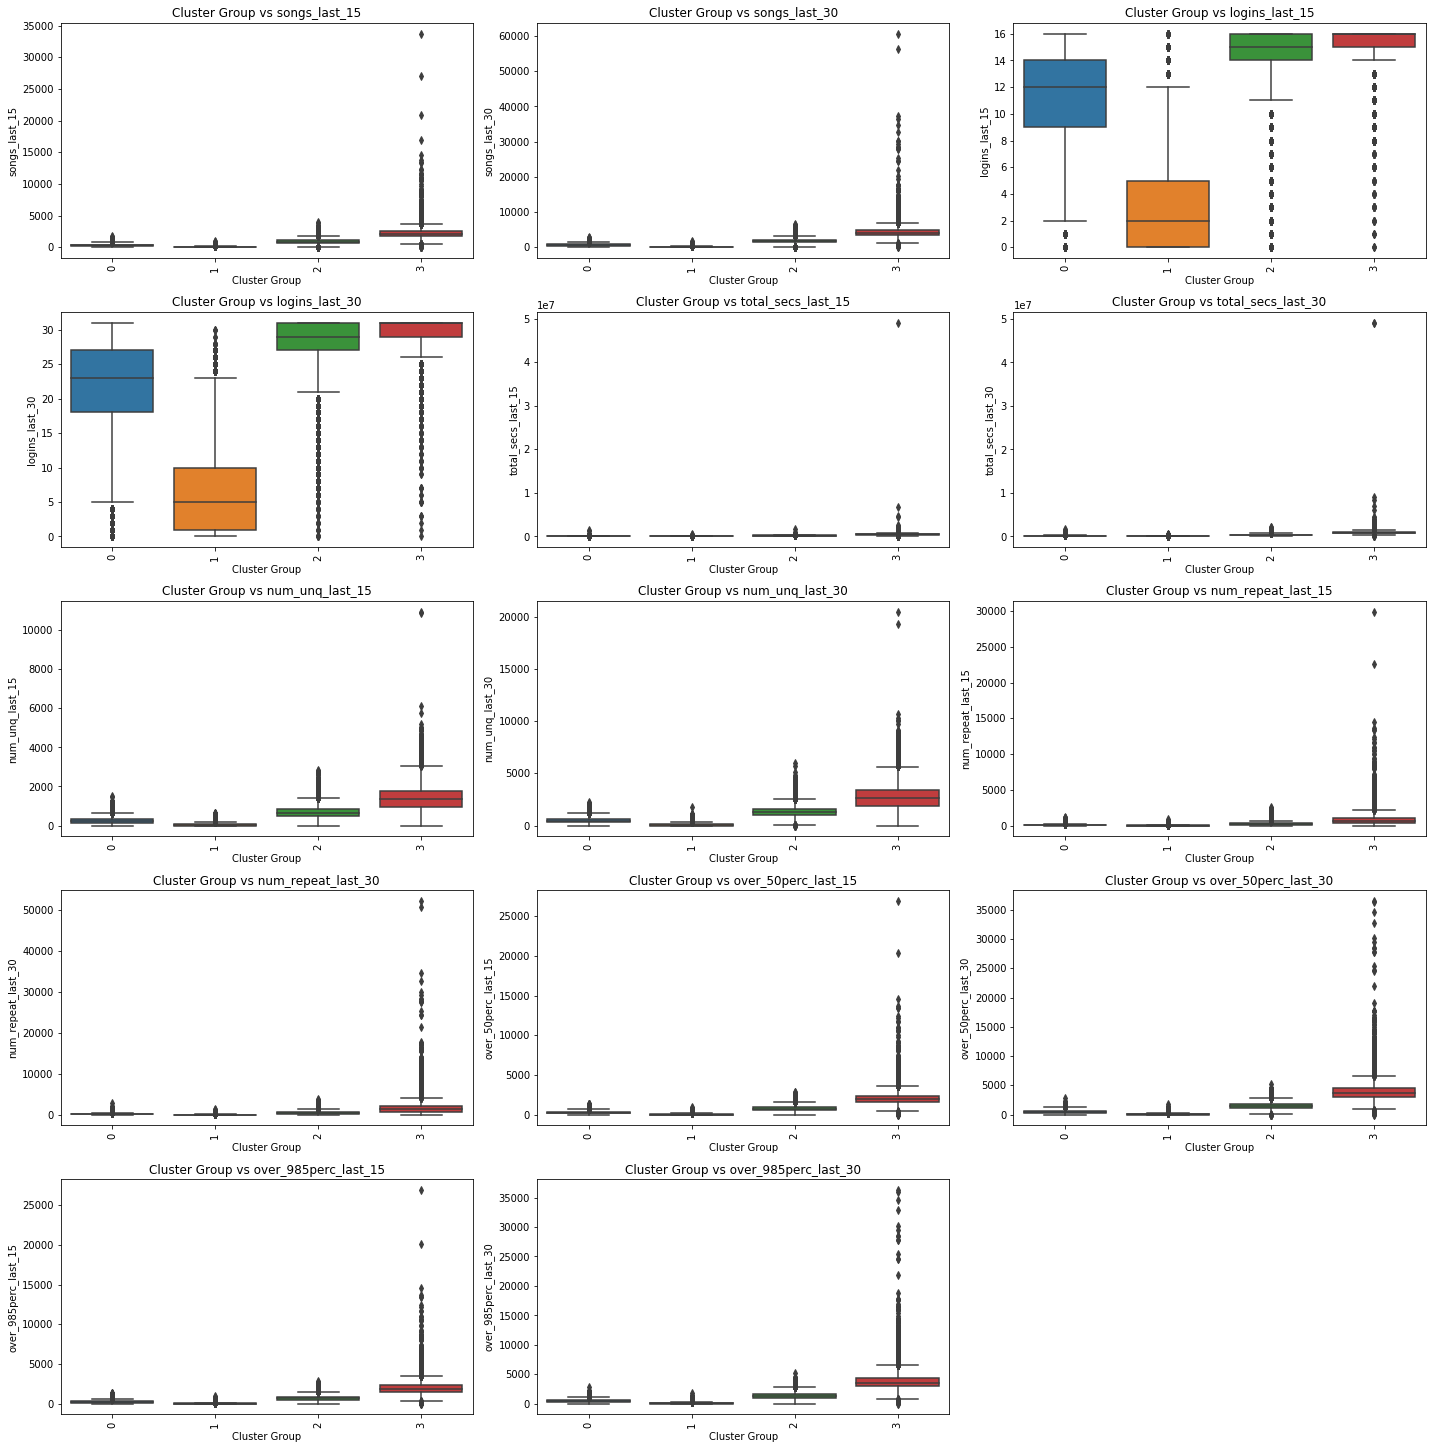

In [36]:
# Categorical TargetVar vs Cont_feats
plt.figure(figsize=(20,60))

for index, column in enumerate(agg_TI_feats):
    plt.subplot(15,3,index+1)
    sns.boxplot(DRV_Jan2016_Clust['Cluster'],DRV_Jan2016_Clust[column])
    plt.title(f"Cluster Group vs {column}")
    plt.ylabel(column)
    plt.xlabel('Cluster Group')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

As expected, and now verified, there isn't much difference in user behavior over our various time intervals. This leads me to believe that each of these groups are quite consistent in their behaviour over time.

### <font color=blue>Cluster Group vs Transaction Features</font>

#### - <font color=purple>*Cluster Group vs Continuous Transaction Features*</font> -

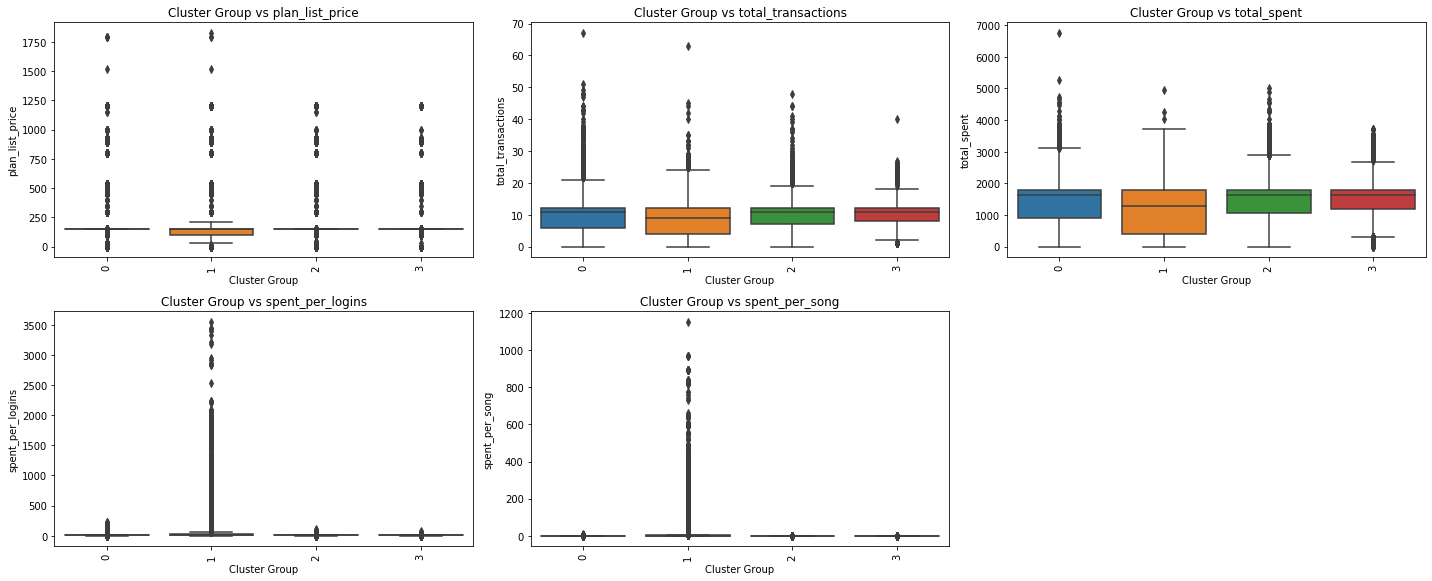

In [40]:
# Categorical TargetVar vs Cont_feats
plt.figure(figsize=(20,60))

for index, column in enumerate(trans_cont_feats):
    plt.subplot(15,3,index+1)
    sns.boxplot(DRV_Jan2016_Clust['Cluster'],DRV_Jan2016_Clust[column])
    plt.title(f"Cluster Group vs {column}")
    plt.ylabel(column)
    plt.xlabel('Cluster Group')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

- It is surprising to see that Cluster 1 Users pay much less than their fellow peers. This is most likely due to having cheaper plan pricing and fewer transactions than the rest of the cohort. 
- Even more surprising is when taking into consideration both money spent and user activity, they are not getting their money's worth!! And they are paying less!!!
- Do discounts mean less user activity and churn? It is a fair question.

#### - <font color=purple>*Cluster Group vs Categorical Transaction Features*</font> -

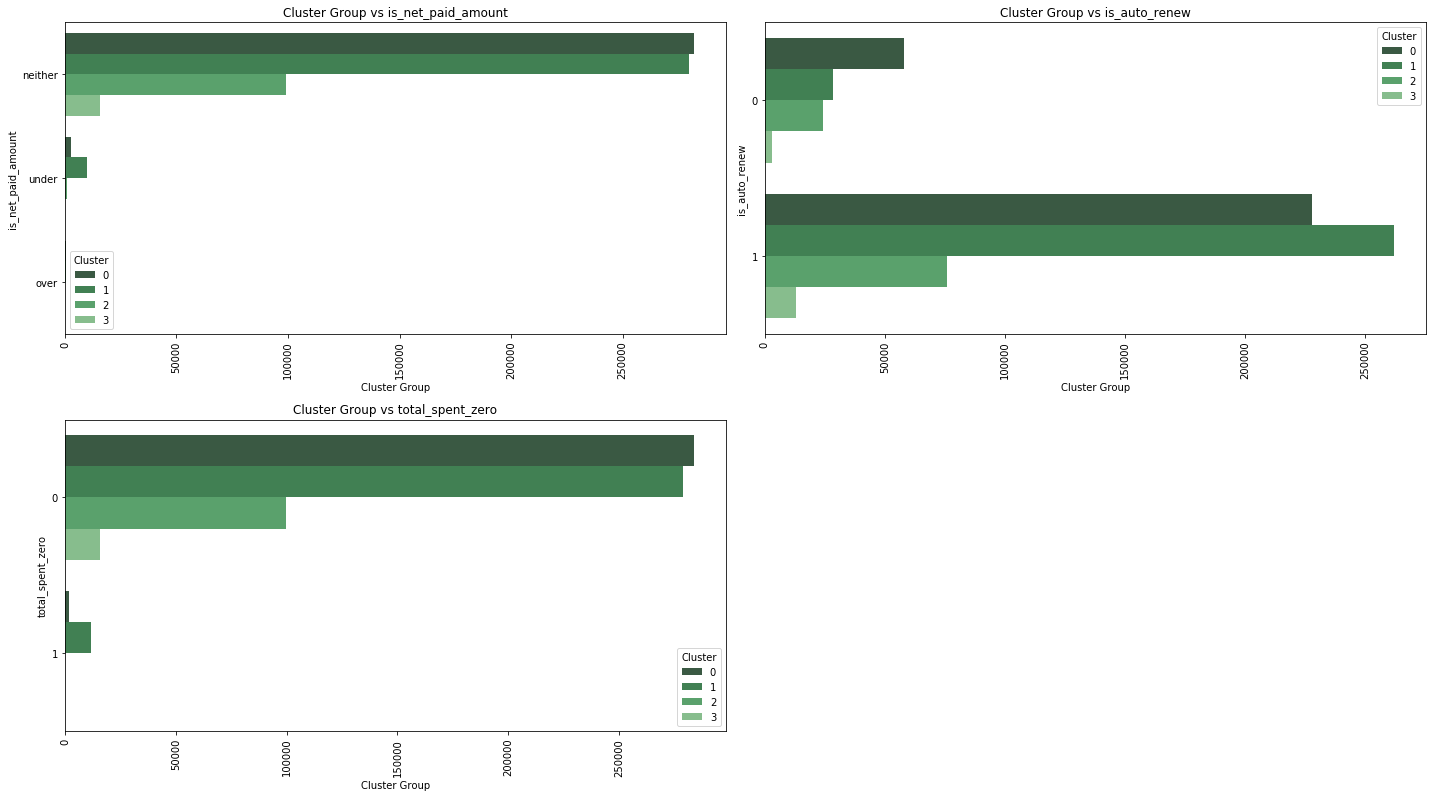

In [34]:
# Categorical TargetVar vs Cont_feats
plt.figure(figsize=(20,60))

for index, column in enumerate(trans_cat_feats):
    plt.subplot(11,2,index+1)
    sns.countplot(y=column, hue='Cluster', data=DRV_Jan2016_Clust, palette="Greens_d")
    plt.title(f"Cluster Group vs {column}")
    plt.ylabel(column)
    plt.xlabel('Cluster Group')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

Although we can make out some differences, Let's translate these bar charts in to crosstab tables.

In [35]:
# Categorical TargetVar vs Cont_feats
plt.figure(figsize=(20,60))

for index, column in enumerate(trans_cat_feats):
    count_table = pd.crosstab(DRV_Jan2016_Clust["Cluster"], DRV_Jan2016_Clust[column])
    print(count_table)
    print('')
    

is_net_paid_amount  neither  over  under
Cluster                                 
0                    282183   553   2867
1                    279935   439   9994
2                     99139   156    790
3                     15728    18     97

is_auto_renew      0       1
Cluster                     
0              57734  227869
1              28447  261921
2              24170   75915
3               2866   12977

total_spent_zero       0      1
Cluster                        
0                 283895   1708
1                 278735  11633
2                  99861    224
3                  15833     10



<Figure size 1440x4320 with 0 Axes>

- Cluster 1 has way more users who under pay their current plan price compared to the rest.
- Cluster 1 also has more than 11.5K users who have NEVER paid a single cent!!

So in continuation to our previous question, ***Do discounts mean less user activity and churn?*** Let's look at both of these with points with respect to Churn.

#### - <font color=green>*Cluster Group 1: Total Spent Zero vs Churn*</font> -

In [49]:
# Total Spent Zero vs Churn - Crosstab Table
index = DRV_Jan2016_Clust[DRV_Jan2016_Clust["Cluster"] == 1]['total_spent_zero']
columns = DRV_Jan2016_Clust[DRV_Jan2016_Clust["Cluster"] == 1]['is_churn']
tsz_churn = pd.crosstab(index,columns)
tsz_churn['Is_Churn %'] = tsz_churn[1] / (tsz_churn[0] + tsz_churn[1])
tsz_churn

is_churn,0,1,Is_Churn %
total_spent_zero,,,
0,270184,8551,0.030678
1,7153,4480,0.385111


38.5% of all users in Cluster 1 who have never paid a single penny for the stream service, churned. 

#### - <font color=green>*Cluster Group 2: Over/Under/Neither Pay vs Churn*</font> -

In [50]:
# Total Spent Zero vs Churn - Crosstab Table
index = DRV_Jan2016_Clust[DRV_Jan2016_Clust["Cluster"] == 1]['is_net_paid_amount']
columns = DRV_Jan2016_Clust[DRV_Jan2016_Clust["Cluster"] == 1]['is_churn']
isnpa_churn = pd.crosstab(index,columns)
isnpa_churn['Is_Churn %'] = isnpa_churn[1] / (isnpa_churn[0] + isnpa_churn[1])
isnpa_churn

is_churn,0,1,Is_Churn %
is_net_paid_amount,,,
neither,270362,9573,0.034197
over,435,4,0.009112
under,6540,3454,0.345607


34.5% of all users in Cluster 1 who currently underpaid their plan price, churned. 